In [1]:
import numpy as np
import pandas as pd
from vertica_python import connect
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
conn_info = {'host': '10.10.4.101',
             'port': 5433,
             'user': 'user_website',
             'password': 'Bytn>pth',
             'database': 'DWH'}
connection = connect(**conn_info)

# Смотрим реестр лицензий

In [289]:
LicenseReestr = pd.read_sql_query("SELECT inn_org, kpp_org, kpp_unit, lic_number_reestr, obshepit, BigGroup, type_activity FROM nsi.LicenseReestr where info_about_lic = 'действующая'", connection)

LicenseReestr.head()

,inn_org,kpp_org,kpp_unit,lic_number_reestr,obshepit,BigGroup,type_activity
0,0101000078,010101001,010145002,01РПА0000462,0.0,799,Розничная продажа алкоголя
1,0101003897,010101001,010145001,01РПА0000530,0.0,799,Розничная продажа алкоголя
2,0101003897,010101001,010145003,01РПА0000530,0.0,799,Розничная продажа алкоголя
3,0101003897,010101001,010145004,01РПА0000530,0.0,799,Розничная продажа алкоголя
4,0101003897,010101001,010145005,01РПА0000530,0.0,799,Розничная продажа алкоголя


# 235 тыс действующих  предприятий всего

In [290]:
LicenseReestr.shape

(235469, 7)

In [291]:
LicenseReestr.obshepit = LicenseReestr.obshepit.astype(str)

In [292]:
LicenseReestr['id'] = LicenseReestr['inn_org'].astype(str) + '_' + LicenseReestr['kpp_org'] + '_' + LicenseReestr['kpp_unit']
LicenseReestr['id'].nunique()
LicenseReestr.head(1)

,inn_org,kpp_org,kpp_unit,lic_number_reestr,obshepit,BigGroup,type_activity,id
0,0101000078,010101001,010145002,01РПА0000462,0.0,799,Розничная продажа алкоголя,0101000078_010101001_010145002


# Из них розничных точек примерно 229 тысяч, в т.ч. 184 магазинов и 45 тыс общепита. Похоже на правду!

In [293]:
pd.pivot_table(LicenseReestr, index='BigGroup', columns='obshepit', values='id', aggfunc='count').fillna(0).astype(int)

obshepit,0.0,1.0,nan
BigGroup,,,
1,0,0,71
3,0,0,167
4,0,0,564
5,0,0,133
6,0,0,39
7,0,0,1687
8,0,0,13
9,0,0,15
10,0,0,97


# Примерно 2400 розничных лицензий не определенных

In [295]:
pd.pivot_table(LicenseReestr[LicenseReestr['BigGroup'].isin([799,800])], index=['BigGroup', 'type_activity'], columns='obshepit', values='id', aggfunc='nunique')

obshepit                                        0.0    1.0   nan
BigGroup type_activity                                          
799      Розничная продажа алкоголя          183050   4432  2373
800      Розничная продажа алкоголя,общепит     678    538    19
         Розничная продажа, общепит              67  38896    27

# Движение будем смотреть по входящим документам из накладных. Потому что по актам списания не удается получить реальную картину,  т.к. там происходят непонятные всплески, эти данные нуждаюся в проверке.

In [151]:
wb = pd.read_sql_query("SELECT  DATE_PART('year' , ActDate) as year, DATE_PART('MONTH' , ActDate) as month, L.inn_org, L.kpp_org, L.kpp_unit, Consignee, type_activity, BigGroup, Consignee_Short_Name, L.address_unit, R.regionName, act.Consignee_Region_Code, max(okrug_name) as okrug_name, act.ProductType_Code, L.obshepit, lic_number_reestr,\
                    sum(act.Count_btl) as Count_btl, sum(act.volume_dal) as volume_dal, sum(act.Quantity*act.Price) as summ_rub, count(distinct wbid) as qnt_wb\
                    FROM data_showcase.WayBill act\
                    inner join nsi.kladr_regions R on R.regionCode = act.Consignee_Region_Code\
                    inner join nsi.kladr_okrugs O on O.okrug_id = R.okrug_id\
                    left join nsi.LicenseReestr L on L.inn_org = act.Consignee_INN and L.kpp_unit =  act.Consignee_KPP  and L.BigGroup in (799, 800)\
                    where act.Type = 'WBInvoiceFromMe' and ActDate>'2019-01-01' and act.isUnpacked=False and act.ProductVid_Code='АП' and L.info_about_lic = 'действующая' and L.obshepit=1\
                    group by DATE_PART('year' , ActDate), DATE_PART('MONTH' , ActDate), L.inn_org, L.kpp_org, L.kpp_unit, Consignee, type_activity, BigGroup, Consignee_Short_Name, L.address_unit, R.regionName, act.Consignee_Region_Code,  act.ProductType_Code, L.obshepit, lic_number_reestr", connection)

wb.head()

,year,month,inn_org,kpp_org,kpp_unit,Consignee,type_activity,BigGroup,Consignee_Short_Name,address_unit,regionName,Consignee_Region_Code,okrug_name,ProductType_Code,obshepit,lic_number_reestr,Count_btl,volume_dal,summ_rub,qnt_wb
0,2019.0,1.0,0104010660,010401001,010401001,020000043970,"Розничная продажа, общепит",800,"ООО ""Юг""","Россия,,Адыгея Респ,Майкопский р-н,,Краснооктя...",АДЫГЕЯ РЕСП,01,Южный федеральный округ,270,1,01РПО0000189,1.0,0.07,1487.33,1
1,2019.0,1.0,0104014551,010401001,010501001,020000753135,"Розничная продажа, общепит",800,"ООО ""АКВА ПОИНТ""","Россия,,АДЫГЕЯ РЕСП,,Майкоп г,,Жуковского ул,1...",АДЫГЕЯ РЕСП,01,Южный федеральный округ,403,1,01РПО0000170,30.0,2.22,2196.48,2
2,2019.0,1.0,0105047302,010501001,010545006,030000299369,"Розничная продажа, общепит",800,"ООО ""Изабелла""","Россия,,Адыгея Респ,,Майкоп г,,Гоголя ул,31,по...",АДЫГЕЯ РЕСП,01,Южный федеральный округ,450,1,01РПО0000138,12.0,0.90,3491.96,2
3,2019.0,1.0,0105053842,010501001,010445001,020000664517,"Розничная продажа, общепит",800,"ООО ""Спектр-Тур""","Россия,,Адыгея Республика,Майкопский Район,,Да...",АДЫГЕЯ РЕСП,01,Южный федеральный округ,500,1,01РПО0000148,140.0,7.00,5950.00,2
4,2019.0,1.0,0105063865,010501001,010501001,020000036038,"Розничная продажа, общепит",800,"ООО ""Лоо""","Россия,,Адыгея Респ,,Майкоп г,,Хакурате 2-я ул...",АДЫГЕЯ РЕСП,01,Южный федеральный округ,200,1,01РПО0000074,113.0,5.65,40197.86,5


In [152]:
wb.shape

(4787611, 20)

# Имеем 3 разных вида активности в общепите, их доли распределены следующим образом

## По количеству контрагентов 

In [307]:
wb.groupby('type_activity')['Consignee'].nunique()

type_activity
Розничная продажа алкоголя             4067
Розничная продажа алкоголя,общепит      515
Розничная продажа, общепит            37006
Name: Consignee, dtype: int64

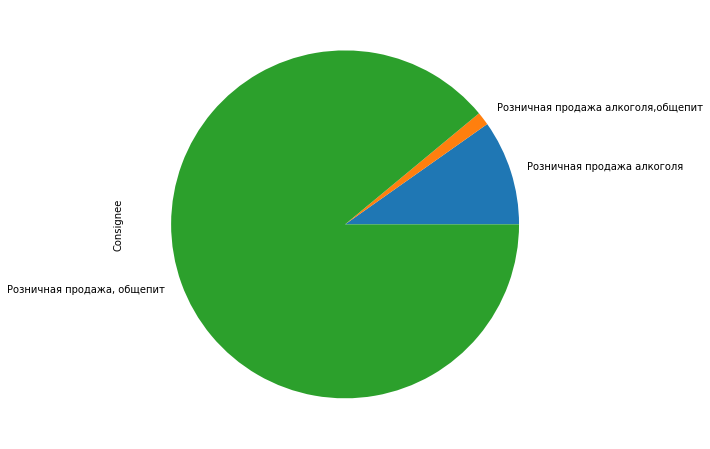

In [305]:
wb.groupby('type_activity')['Consignee'].nunique().plot.pie(figsize=(8,8))

In [306]:
## По обороту в рублях 

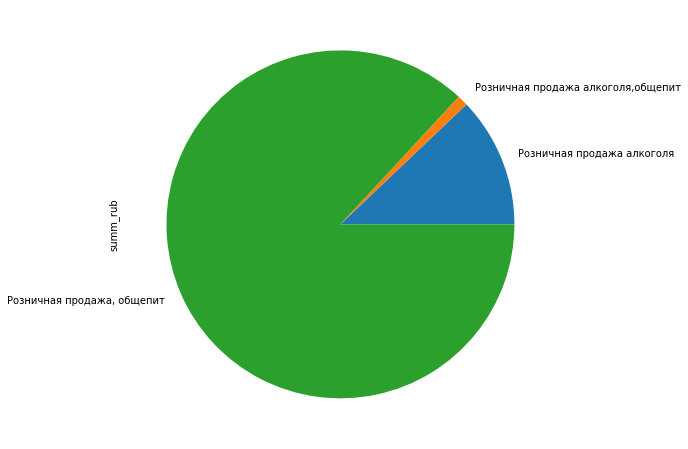

In [304]:
(wb.groupby('type_activity')['summ_rub'].sum()/10**9).plot.pie(figsize=(8,8))

In [166]:
wb[wb['type_activity']=='Розничная продажа алкоголя'].head(30)#.to_excel('/run/user/1000/gvfs/smb-share:server=10.32.0.81,share=users/Magomedov-az/Documents/sync/obrazets.xlsx')

In [169]:
wb[wb['inn_org']=='0326027142'].address_unit.unique()

array(['Россия,,Бурятия Республика,,Улан-Удэ Город,,Гагарина Улица,43,,,',
       'Россия,,Бурятия Республика,,Улан-Удэ Город,,Хоца Намсараева Улица,7а,,,'],
      dtype=object)

In [171]:
wb.shape

(4787611, 20)

# Классификатор тайп кодов, для разделения по продукции по большим группам

In [170]:
Type_group = pd.read_csv(r'/run/user/1000/gvfs/smb-share:server=10.32.0.81,share=users/Magomedov-az/Documents/sync/Type_codes_name.csv', sep='\t', encoding='cp1251')
Type_group.head()

,id,id_group,name_group,code_type,Kode,NameDesc
0,55,1,Спиртные напитки свыше 25%,200,200,Водка
1,2,1,Спиртные напитки свыше 25%,212,212,Ликероводочные изделия с содержанием этилового...
2,3,1,Спиртные напитки свыше 25%,230,"229, 230, 232, 233, 234, 235, 239, 242","Коньяк, арманьяк, бренди, коньяк с ЗГУ, коньяк..."
3,5,1,Спиртные напитки свыше 25%,232,"229, 230, 232, 233, 234, 235, 239, 242","Коньяк, арманьяк, бренди, коньяк с ЗГУ, коньяк..."
4,6,1,Спиртные напитки свыше 25%,233,"229, 230, 232, 233, 234, 235, 239, 242","Коньяк, арманьяк, бренди, коньяк с ЗГУ, коньяк..."


In [172]:
wb['year_mon'] = wb['year']*100 + wb['month']
wb[['year_mon','year', 'month']] = wb[['year_mon','year', 'month']].astype(int)
wb.head(1)

,year,month,inn_org,kpp_org,kpp_unit,Consignee,type_activity,BigGroup,Consignee_Short_Name,address_unit,regionName,Consignee_Region_Code,okrug_name,ProductType_Code,obshepit,lic_number_reestr,Count_btl,volume_dal,summ_rub,qnt_wb,year_mon
0,2019,1,0104010660,010401001,010401001,020000043970,"Розничная продажа, общепит",800,"ООО ""Юг""","Россия,,Адыгея Респ,Майкопский р-н,,Краснооктя...",АДЫГЕЯ РЕСП,01,Южный федеральный округ,270,1,01РПО0000189,1.0,0.07,1487.33,1,201901


In [176]:
Type_group.code_type = Type_group.code_type.astype(int)
wb.ProductType_Code = wb.ProductType_Code.astype(int)

In [300]:
wb = wb.merge(Type_group.rename(columns={'code_type':'ProductType_Code'}), on ='ProductType_Code')
print(wb.shape)
wb.head(1)

(4748345, 31)


,year,month,inn_org,kpp_org,kpp_unit,Consignee,type_activity,BigGroup,Consignee_Short_Name,address_unit,regionName,Consignee_Region_Code,okrug_name,ProductType_Code,obshepit,lic_number_reestr,Count_btl,volume_dal,summ_rub,qnt_wb,year_mon,id_x,id_group_x,name_group_x,Kode_x,NameDesc_x,id_y,id_group_y,name_group_y,Kode_y,NameDesc_y
0,2019,1,0104010660,010401001,010401001,020000043970,"Розничная продажа, общепит",800,"ООО ""Юг""","Россия,,Адыгея Респ,Майкопский р-н,,Краснооктя...",АДЫГЕЯ РЕСП,01,Южный федеральный округ,270,1,01РПО0000189,1.0,0.07,1487.33,1,201901,19,2,Спиртные напитки свыше 9% до 25%,"211, 238, 241, 270","Ликероводочные изделия, напитки коньячные, бре...",19,2,Спиртные напитки свыше 9% до 25%,"211, 238, 241, 270","Ликероводочные изделия, напитки коньячные, бре..."


In [199]:
wb = wb.drop(wb[wb['Consignee_Short_Name']=='ООО "Фаэтон Трейд"'].index)
# wb[wb['Consignee_Short_Name']=='ООО "Фаэтон Трейд"'].index

In [387]:
%store wb

Stored 'wb' (DataFrame)


In [302]:
# wb.groupby('Consignee_Short_Name')['summ_rub'].sum().sort_values(ascending=False)#.plot.hist(bins=100)

# Смотрим суммарную активность предприятий общепита за период с начала 2019 по конец мая 2020. В деньгах (в закупочных ценах), в ДАЛах и по количеству активных контрагентов по месяцам

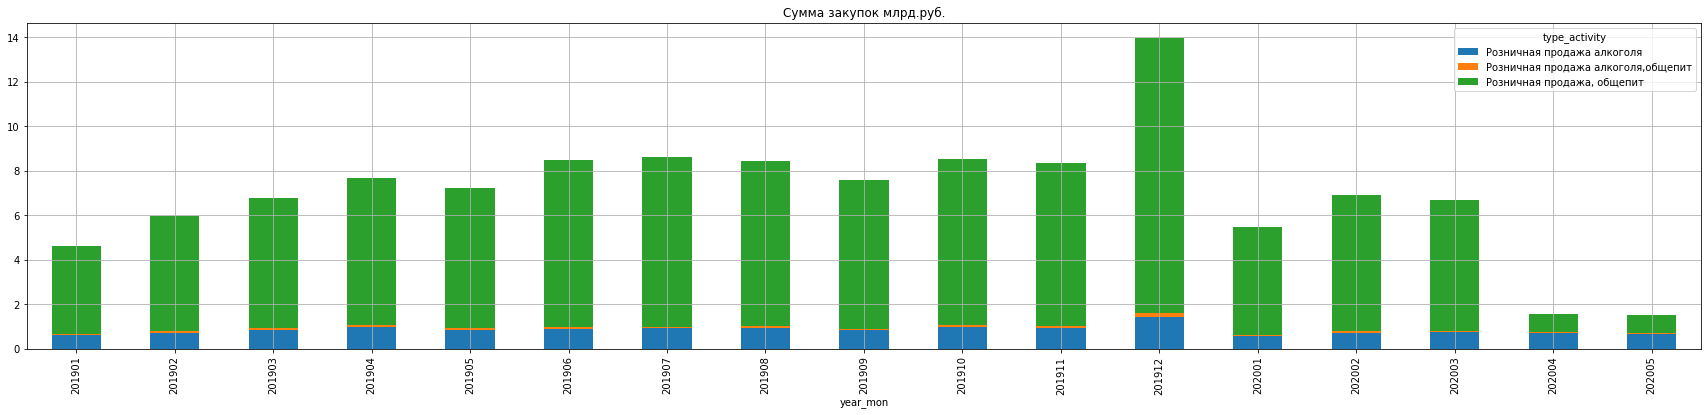

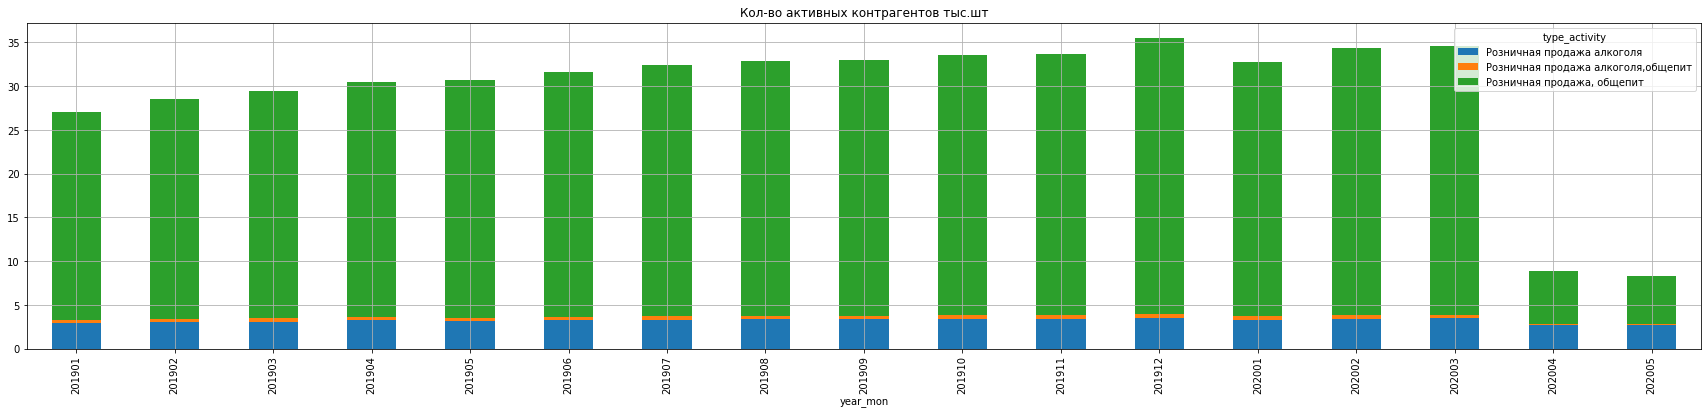

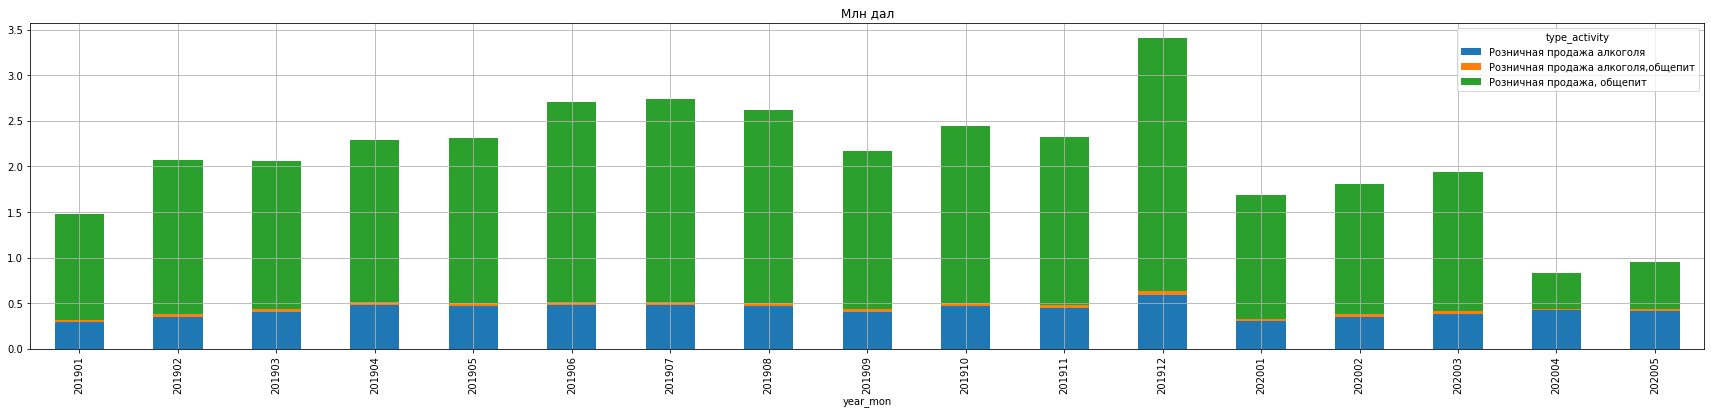

In [299]:
wb = wb[wb['year_mon']<202006]
pd.pivot_table(wb, index='year_mon', columns='type_activity', values='summ_rub', aggfunc= lambda x: x.sum()/10**9).plot.bar(figsize=(30,6), stacked=True, grid=True, title='Сумма закупок млрд.руб.');
pd.pivot_table(wb, index='year_mon', columns='type_activity', values='Consignee', aggfunc= lambda x: x.nunique()/10**3).plot.bar(figsize=(30,6), stacked=True, grid=True, title='Кол-во активных контрагентов тыс.шт');
pd.pivot_table(wb, index='year_mon', columns='type_activity', values='volume_dal', aggfunc= lambda x: x.sum()/10**6).plot.bar(figsize=(30,6), stacked=True, grid=True, title='Млн дал');

# Посмотрим какие виды продукции больше коснулся карантин. В динамике и в сравнении с прошлым годом.

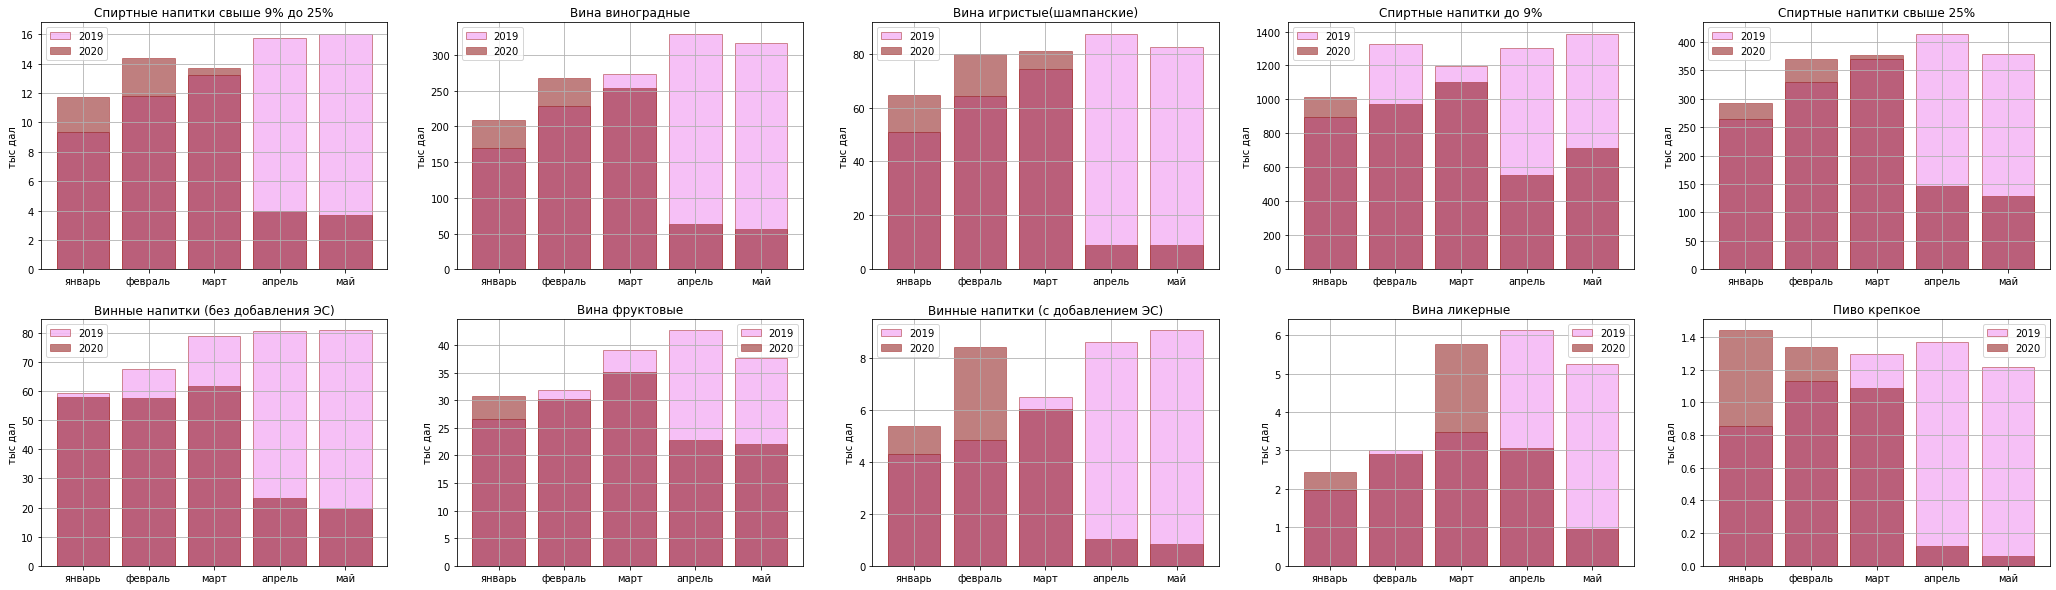

In [284]:
plt.figure(figsize=(36, 10))
for i in enumerate(wb.name_group.unique()):
    plt.subplot(2, 5, i[0] + 1)
    plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['name_group']==i[1])].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
           edgecolor='brown', linewidth=1, color='violet', label='2019', alpha=0.5)
    plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['name_group']==i[1])].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
           edgecolor='brown', linewidth=1, color='maroon', label='2020', alpha=0.5)
    plt.title(i[1])
    plt.grid()
    plt.legend()
    plt.ylabel('тыс дал')
plt.show();

# То же самое по округам 

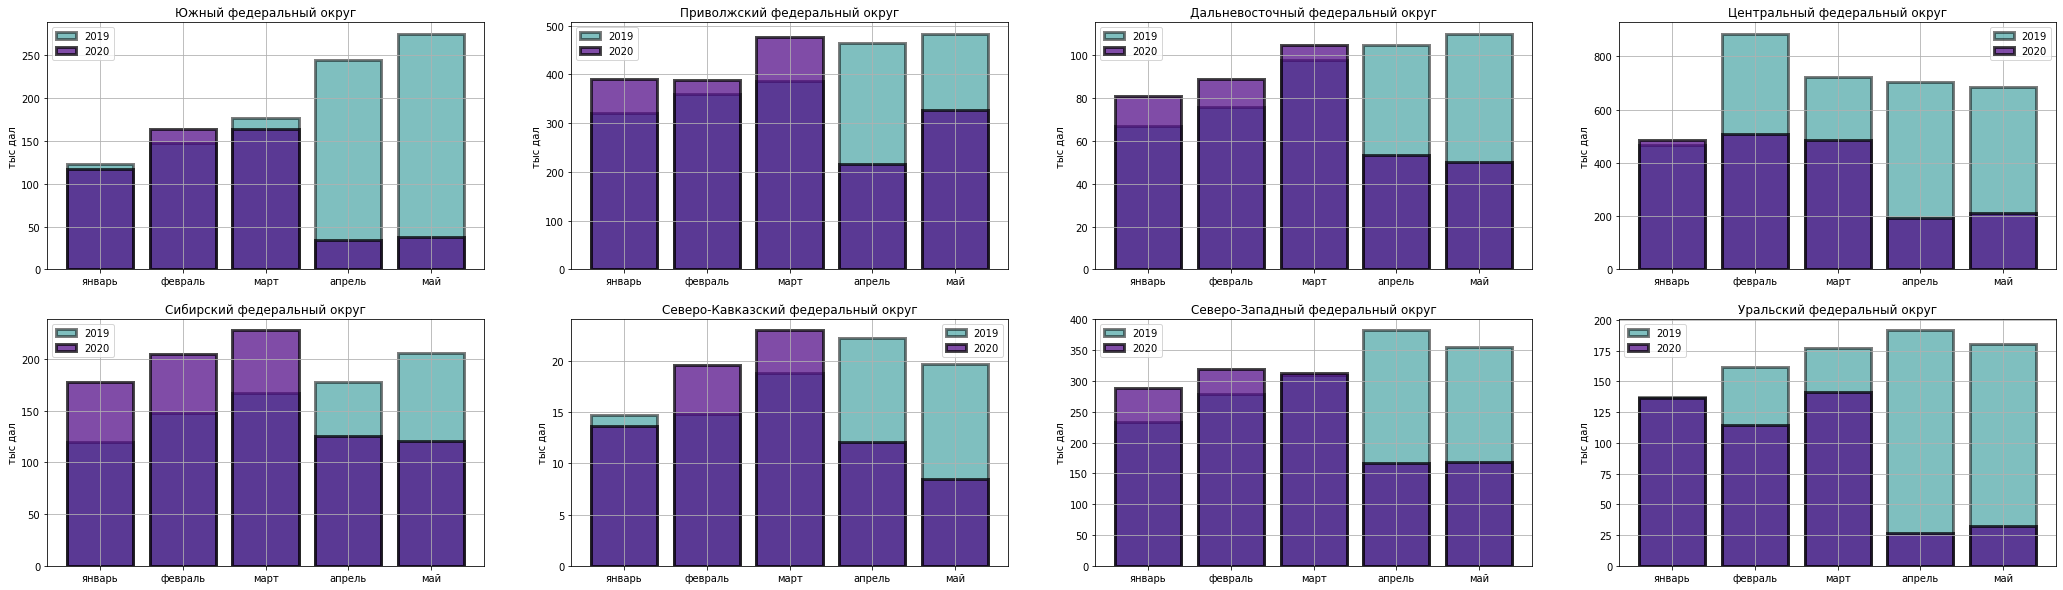

In [285]:
plt.figure(figsize=(36, 10))
for i in enumerate(wb.okrug_name.unique()):
    plt.subplot(2, 4, i[0] + 1)
    plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['okrug_name']==i[1])].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
           edgecolor='black', linewidth=3, color='teal', label='2019', alpha=0.5)
    plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['okrug_name']==i[1])].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
           edgecolor='black', linewidth=3, color='indigo', label='2020', alpha=0.7)

    plt.title(i[1])
    plt.grid()
    plt.legend()
    plt.ylabel('тыс дал')
plt.show();

# И по регионам

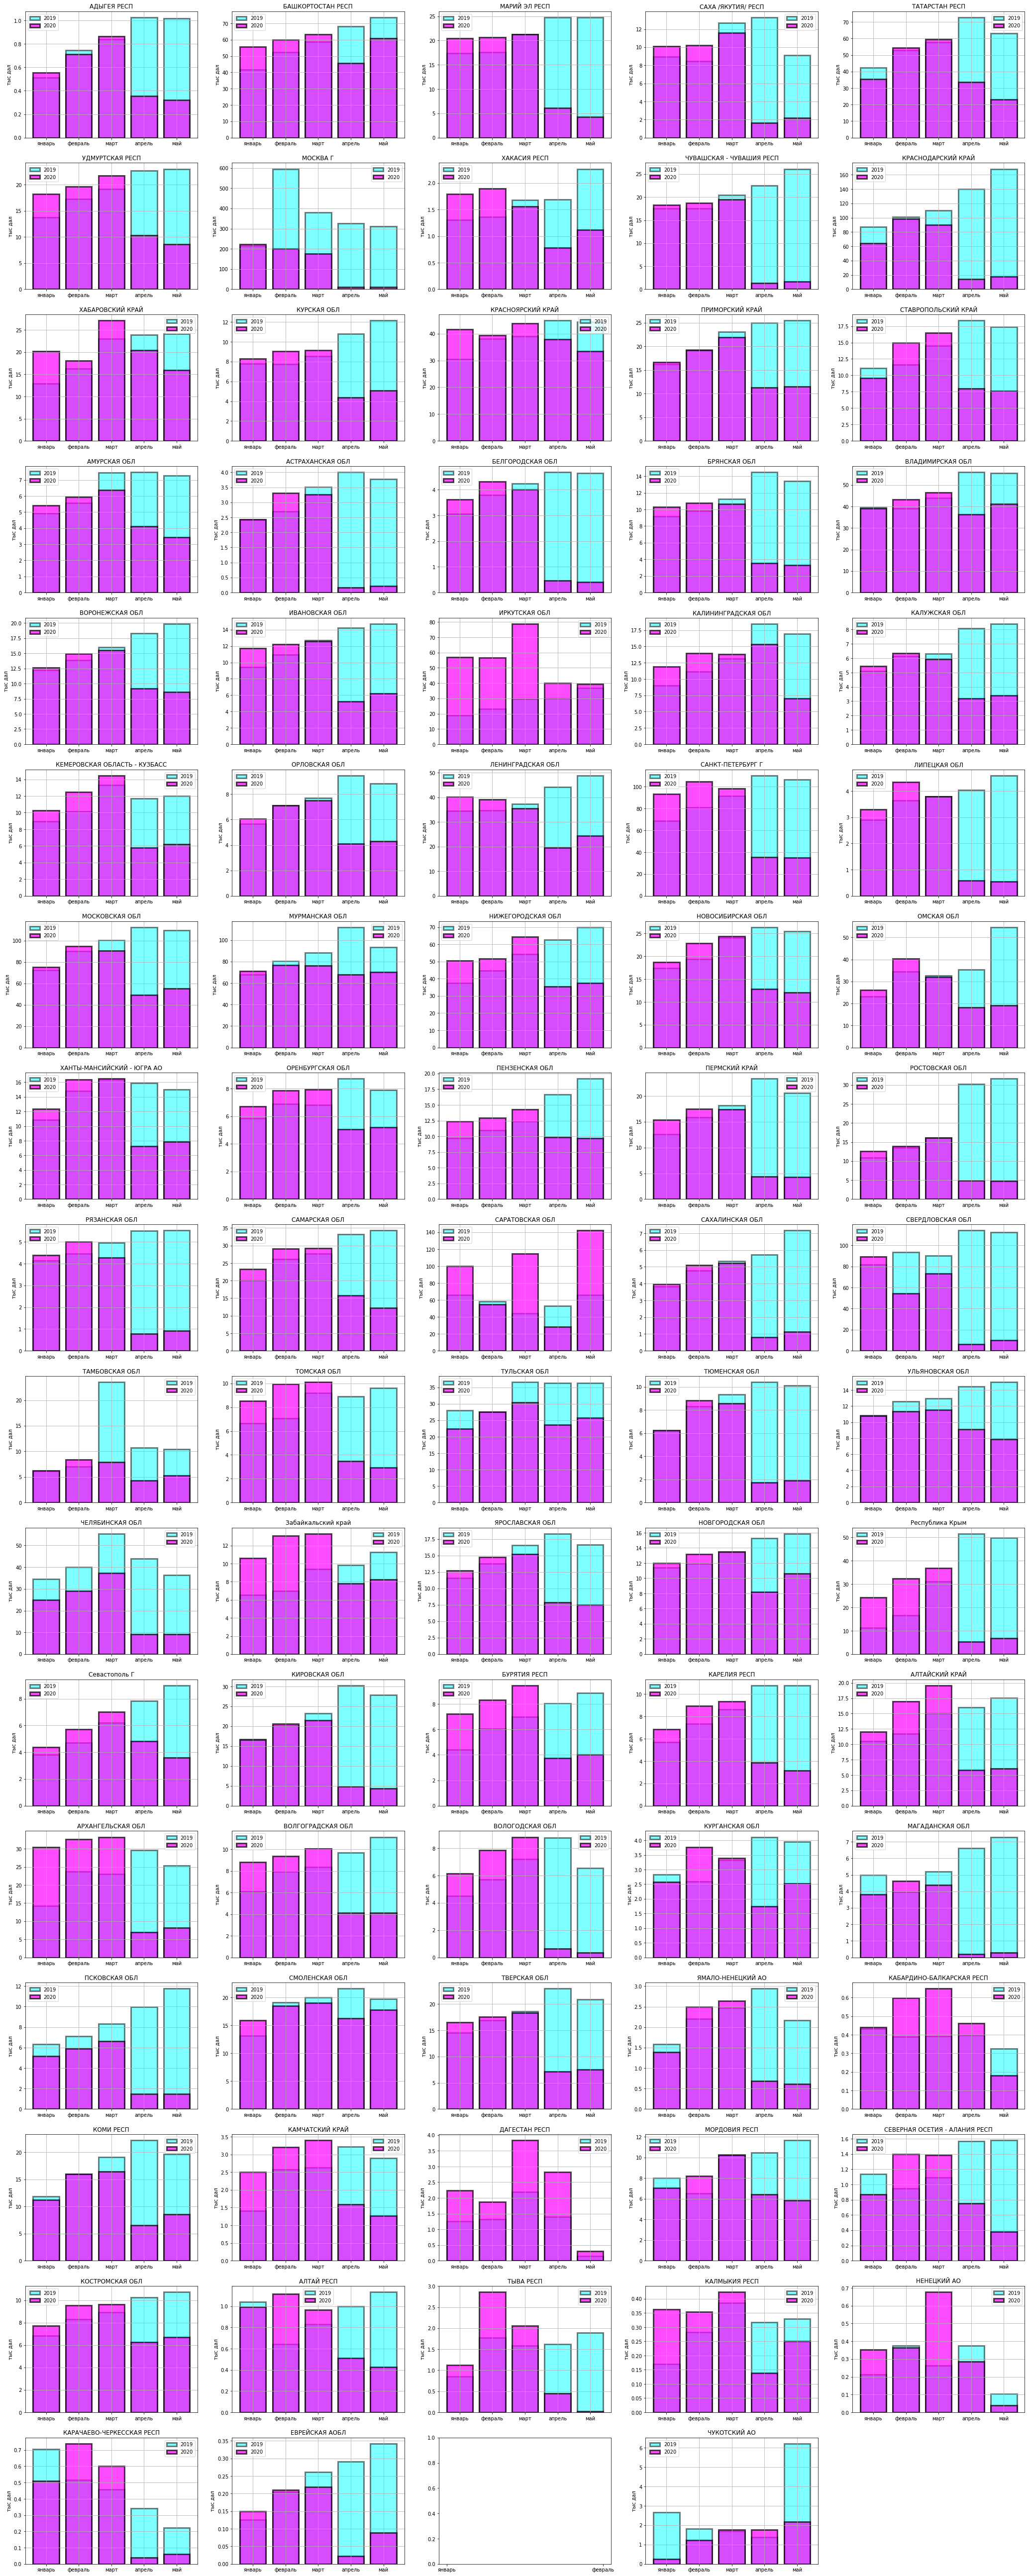

In [286]:
plt.figure(figsize=(36, 100))
for i in range(len(wb.regionName.unique())):
    try:
        reg = wb.regionName.unique()[i]
        plt.subplot(18, 5, i + 1)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['regionName']==reg)].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='cyan', label='2019', alpha=0.5)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['regionName']==reg)].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='magenta', label='2020', alpha=0.7)
        plt.title(reg)
        plt.grid()
        plt.legend()
        plt.ylabel('тыс дал')
    except ValueError:
        pass
plt.show();

In [283]:
wb.regionName.unique()[-2]

'ЧЕЧЕНСКАЯ РЕСП'

### Пустой график в конце это Чечня

# Вывод: 1) Более 70% предприятий общепита прекратили свою деятельность. Общее падение выручки в сегменте также превышает 70%  2)  Степень потерь и динамика активности в регионах существенно отличается друг от друга

# <span style="color:blue">Продолжение, после обсуждения.</span>

# Топ 10 регионов по обороту

In [311]:
wb.groupby('regionName')['summ_rub'].sum().sort_values(ascending=False).head(10)

regionName
МОСКВА Г              2.660563e+10
САНКТ-ПЕТЕРБУРГ Г     9.230970e+09
КРАСНОДАРСКИЙ КРАЙ    8.720291e+09
МОСКОВСКАЯ ОБЛ        5.959352e+09
СВЕРДЛОВСКАЯ ОБЛ      4.007886e+09
ТАТАРСТАН РЕСП        3.059584e+09
Республика Крым       2.780784e+09
НИЖЕГОРОДСКАЯ ОБЛ     2.758839e+09
МУРМАНСКАЯ ОБЛ        2.755759e+09
БАШКОРТОСТАН РЕСП     2.678464e+09
Name: summ_rub, dtype: float64

In [313]:
list_big_reg = wb.groupby('regionName')['summ_rub'].sum().sort_values(ascending=False).head(10).index
list_big_reg

Index(['МОСКВА Г', 'САНКТ-ПЕТЕРБУРГ Г', 'КРАСНОДАРСКИЙ КРАЙ', 'МОСКОВСКАЯ ОБЛ',
       'СВЕРДЛОВСКАЯ ОБЛ', 'ТАТАРСТАН РЕСП', 'Республика Крым',
       'НИЖЕГОРОДСКАЯ ОБЛ', 'МУРМАНСКАЯ ОБЛ', 'БАШКОРТОСТАН РЕСП'],
      dtype='object', name='regionName')

# Оценку активности попробуем дать в сумме, в далах, в количестве контрагентов и документов, для объективности.

# Топ 10 регионов (млрд. руб) (тип активности только 'Розничная продажа, общепит')

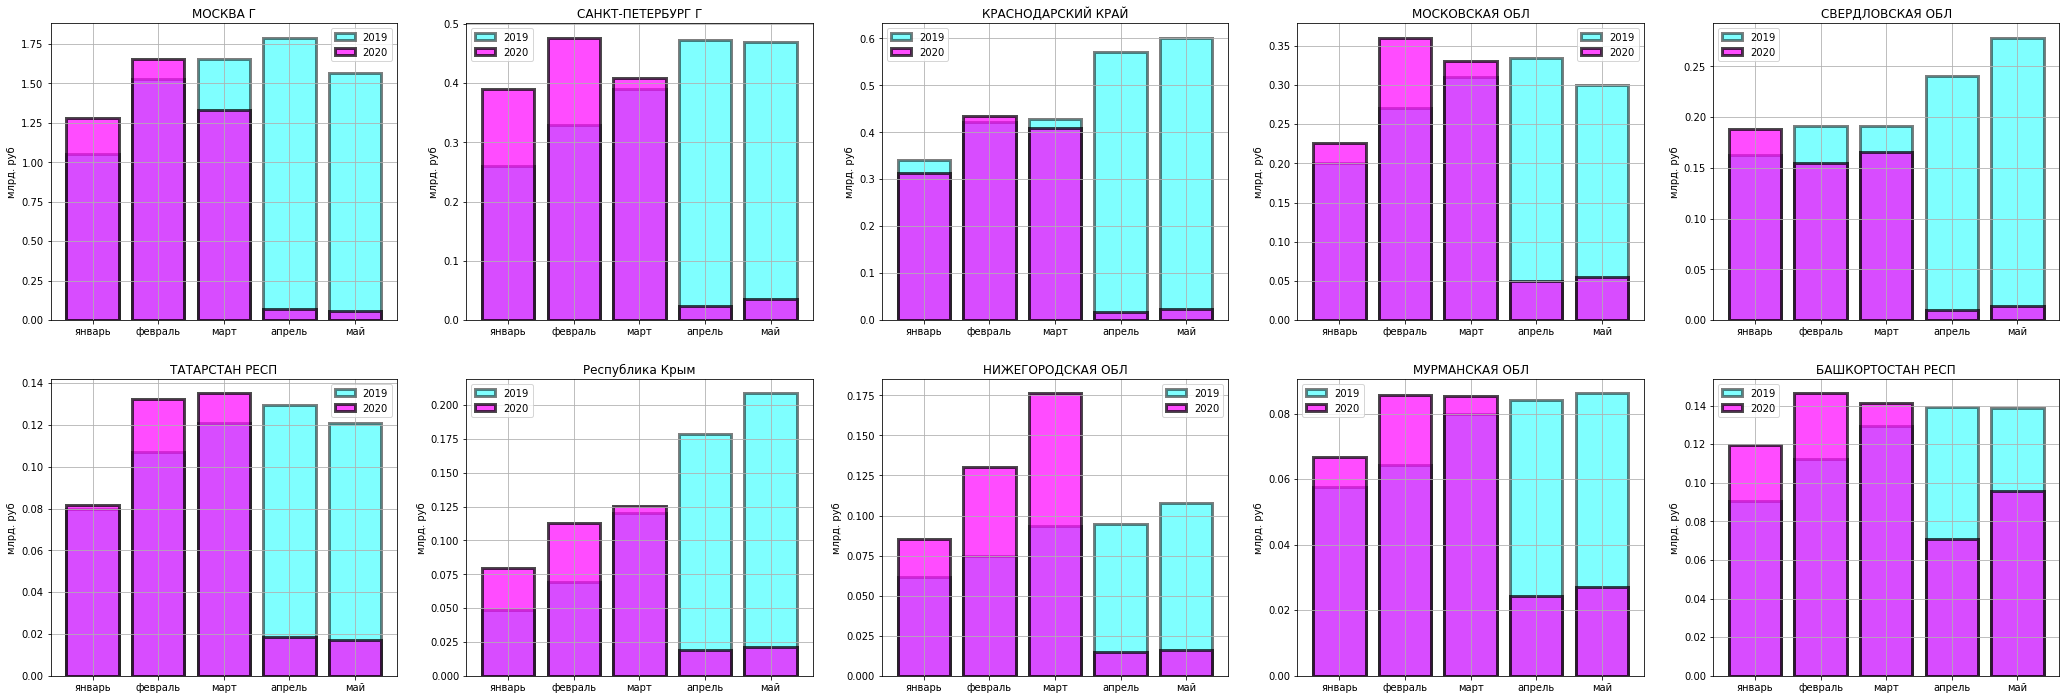

In [315]:
plt.figure(figsize=(36, 12))
for i in range(len(list_big_reg)):
    try:
        reg = list_big_reg[i]
        plt.subplot(2, 5, i + 1)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['summ_rub'].agg(lambda x: x.sum()/10**9).values,
               edgecolor='black', linewidth=3, color='cyan', label='2019', alpha=0.5)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['summ_rub'].agg(lambda x: x.sum()/10**9).values,
               edgecolor='black', linewidth=3, color='magenta', label='2020', alpha=0.7)
        plt.title(reg)
        plt.grid()
        plt.legend()
        plt.ylabel('млрд. руб')
    except ValueError:
        pass
plt.show();

# Топ 10 регионов (тыс. дал) (тип активности только 'Розничная продажа, общепит')

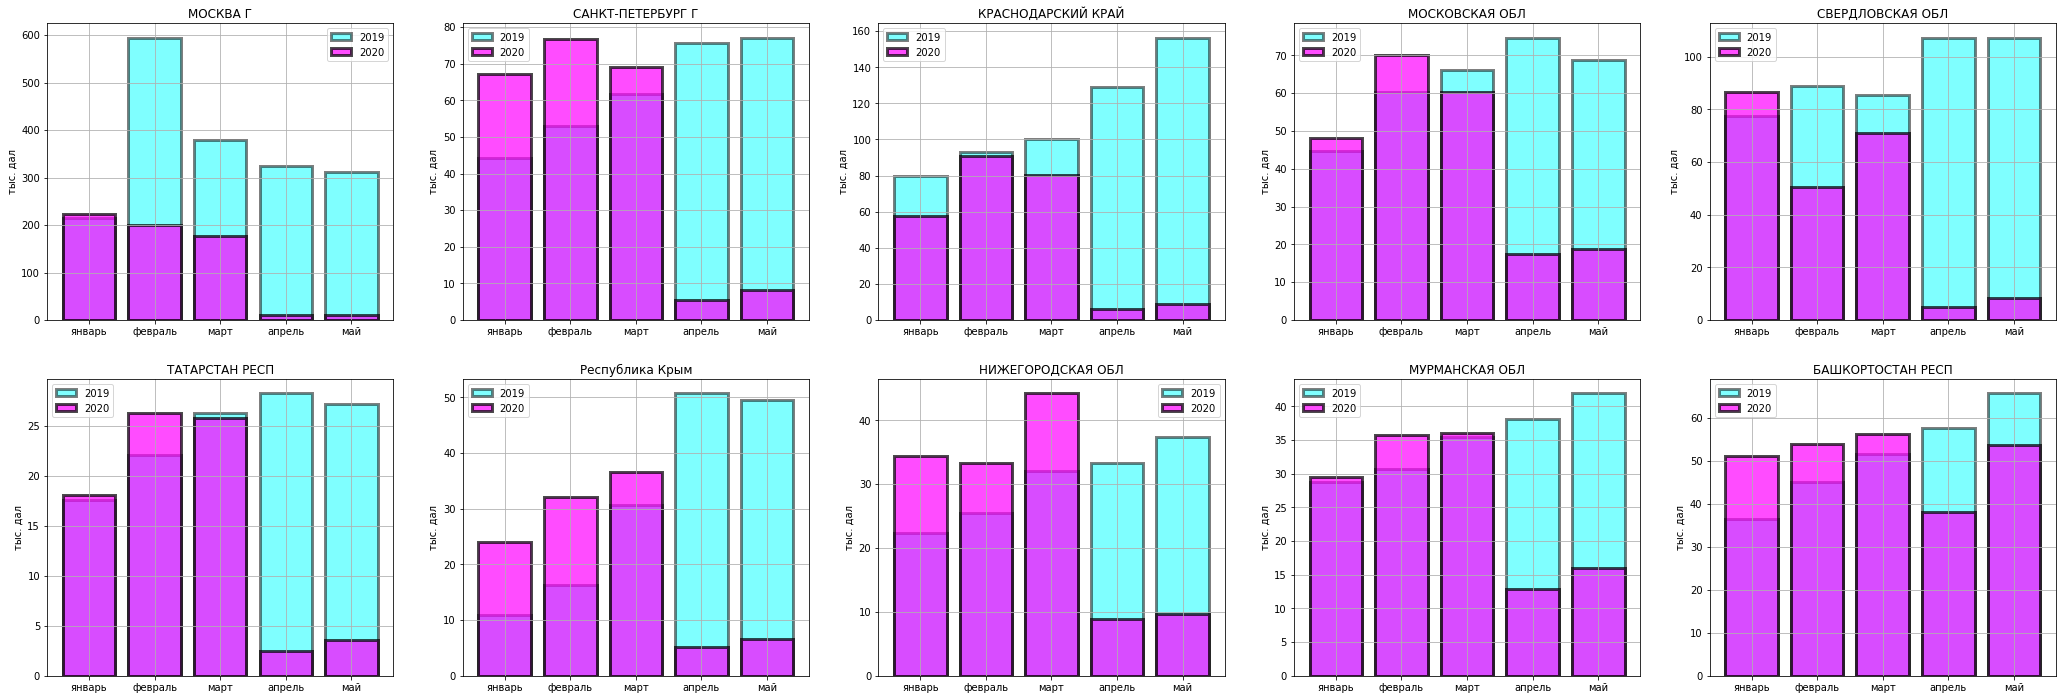

In [316]:
plt.figure(figsize=(36, 12))
for i in range(len(list_big_reg)):
    try:
        reg = list_big_reg[i]
        plt.subplot(2, 5, i + 1)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='cyan', label='2019', alpha=0.5)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['volume_dal'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='magenta', label='2020', alpha=0.7)
        plt.title(reg)
        plt.grid()
        plt.legend()
        plt.ylabel('тыс. дал')
    except ValueError:
        pass
plt.show();

# Топ 10 регионов. Количество активных контрагентов (тип активности только 'Розничная продажа, общепит')

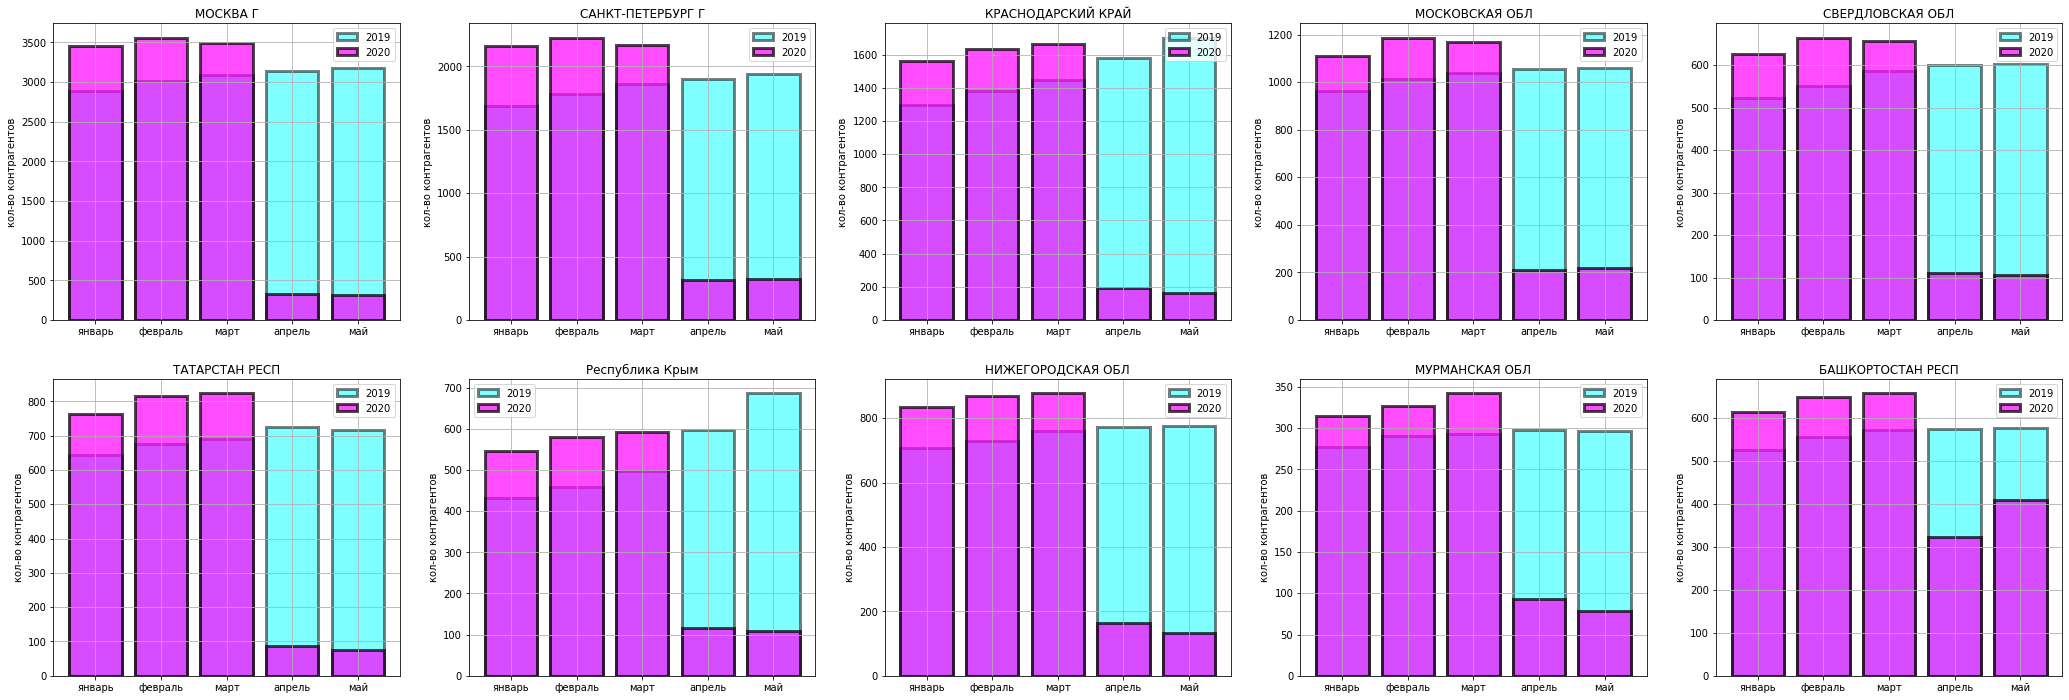

In [317]:
plt.figure(figsize=(36, 12))
for i in range(len(list_big_reg)):
    try:
        reg = list_big_reg[i]
        plt.subplot(2, 5, i + 1)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['Consignee'].agg(lambda x: x.nunique()).values,
               edgecolor='black', linewidth=3, color='cyan', label='2019', alpha=0.5)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['Consignee'].agg(lambda x: x.nunique()).values,
               edgecolor='black', linewidth=3, color='magenta', label='2020', alpha=0.7)
        plt.title(reg)
        plt.grid()
        plt.legend()
        plt.ylabel('кол-во контрагентов')
    except ValueError:
        pass
plt.show();

# Топ 10 регионов. Число документов (тип активности только 'Розничная продажа, общепит')

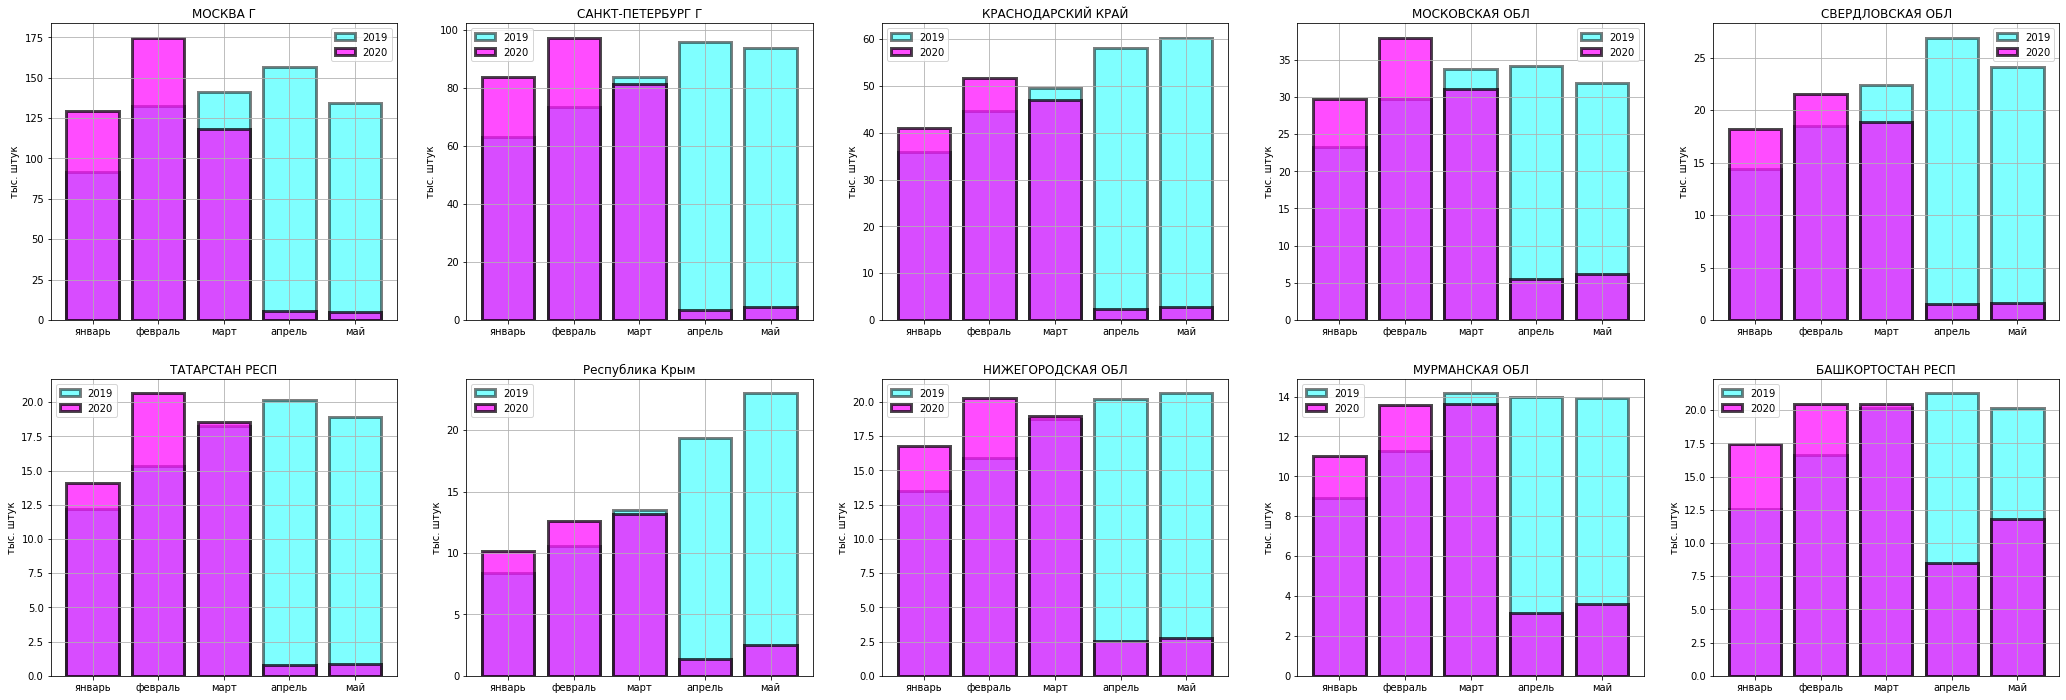

In [318]:
plt.figure(figsize=(36, 12))
for i in range(len(list_big_reg)):
    try:
        reg = list_big_reg[i]
        plt.subplot(2, 5, i + 1)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['qnt_wb'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='cyan', label='2019', alpha=0.5)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['qnt_wb'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='magenta', label='2020', alpha=0.7)
        plt.title(reg)
        plt.grid()
        plt.legend()
        plt.ylabel('тыс. штук')
    except ValueError:
        pass
plt.show();

# АнтиТоп 10 по дисциплине карантина

In [327]:
(wb[(wb['year']==2020) & (wb['month'].isin([4,5]) ) &(wb['type_activity']=='Розничная продажа, общепит')].groupby('regionName')['summ_rub'].agg(lambda x: x.sum()/10**9)\
/wb[(wb['year']==2019) & (wb['month'].isin([4,5]) ) &(wb['type_activity']=='Розничная продажа, общепит')].groupby('regionName')['summ_rub'].agg(lambda x: x.sum()/10**9)).sort_values(ascending=False).head(10)

regionName
ДАГЕСТАН РЕСП                3.013045
БАШКОРТОСТАН РЕСП            0.599595
САРАТОВСКАЯ ОБЛ              0.593112
СМОЛЕНСКАЯ ОБЛ               0.518033
УЛЬЯНОВСКАЯ ОБЛ              0.488826
НЕНЕЦКИЙ АО                  0.468392
ХАКАСИЯ РЕСП                 0.436991
КАЛИНИНГРАДСКАЯ ОБЛ          0.425534
ХАБАРОВСКИЙ КРАЙ             0.392409
КАБАРДИНО-БАЛКАРСКАЯ РЕСП    0.360351
Name: summ_rub, dtype: float64

In [328]:
anti_top = (wb[(wb['year']==2020) & (wb['month'].isin([4,5]) ) &(wb['type_activity']=='Розничная продажа, общепит')].groupby('regionName')['summ_rub'].agg(lambda x: x.sum()/10**9)\
/wb[(wb['year']==2019) & (wb['month'].isin([4,5]) ) &(wb['type_activity']=='Розничная продажа, общепит')].groupby('regionName')['summ_rub'].agg(lambda x: x.sum()/10**9)).sort_values(ascending=False).head(10).index

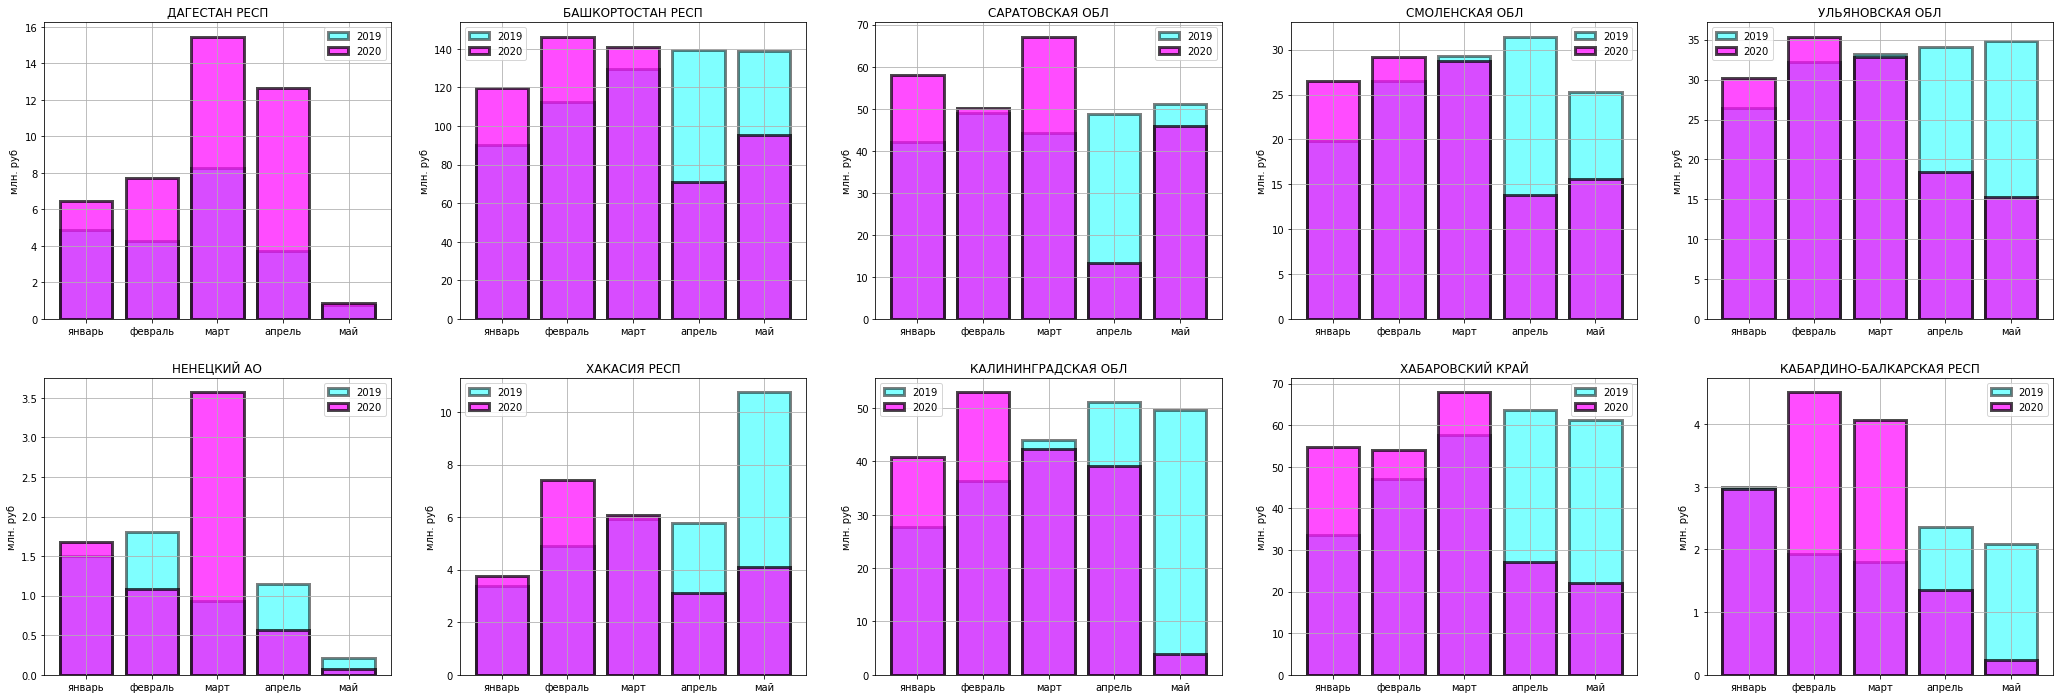

In [330]:
plt.figure(figsize=(36, 12))
for i in range(len(anti_top)):
    try:
        reg = anti_top[i]
        plt.subplot(2, 5, i + 1)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['summ_rub'].agg(lambda x: x.sum()/10**6).values,
               edgecolor='black', linewidth=3, color='cyan', label='2019', alpha=0.5)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['regionName']==reg) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['summ_rub'].agg(lambda x: x.sum()/10**6).values,
               edgecolor='black', linewidth=3, color='magenta', label='2020', alpha=0.7)
        plt.title(reg)
        plt.grid()
        plt.legend()
        plt.ylabel('млн. руб')
    except ValueError:
        pass
plt.show();

# Берем топ 100 контрагентов, у которых в течение всего времени были движения по документам (контрагент может содержать несколько точек)

In [386]:
non_stop_worked = pd.pivot_table(wb[(wb['type_activity']=='Розничная продажа, общепит')], index=['Consignee_Short_Name', 'regionName'], columns='year_mon', values='summ_rub', aggfunc=lambda x: x.sum()/10**3).dropna()
non_stop_worked.head(10)

,year_mon,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004,202005
Consignee_Short_Name,regionName,,,,,,,,,,,,,,,,,
"""АБСОЛЮТ""",ВОРОНЕЖСКАЯ ОБЛ,70.471080,143.847440,155.480440,168.183970,78.961840,86.192360,194.394510,175.228260,139.384460,128.498660,835.171720,193.518120,43.98143,119.952180,72.767960,8.98200,9.568800
"""АВЕРС""",ВОРОНЕЖСКАЯ ОБЛ,92.983570,156.229650,152.112720,140.299210,200.569520,171.659230,151.184600,226.752360,65.907840,46.386630,56.251070,74.597700,8.67440,54.299480,196.845480,39.75891,152.450660
"""АЛЬФА""",МОСКВА Г,213.442095,366.597728,341.237768,396.710180,296.277780,238.441710,334.000230,327.279070,283.699919,321.549919,341.841660,554.666700,318.19083,262.458540,231.760550,27.94356,12.528720
"""АНИ АРМ""",АМУРСКАЯ ОБЛ,259.534100,230.954160,458.638320,666.877090,495.904120,157.738080,498.764000,541.368480,338.187160,408.143360,738.115410,511.418480,345.68806,292.551960,277.765810,29.96292,17.314200
"""Альком""",ВОРОНЕЖСКАЯ ОБЛ,9.100890,28.058470,19.024480,20.770810,25.516350,25.434750,28.107010,40.672290,16.208400,20.969840,30.564350,47.638790,35.99030,19.953250,8.264880,10.43198,7.399440
"""Альянс""",ВОРОНЕЖСКАЯ ОБЛ,289.458300,185.000830,311.449780,252.881340,425.502000,349.681230,435.821850,330.823680,382.169570,302.906970,334.415760,495.426230,202.27656,280.966690,357.628510,496.43586,388.424400
"""Аннушка""",КАЛУЖСКАЯ ОБЛ,35.261630,108.935259,99.635550,160.008660,172.729710,212.523490,279.232317,149.338559,133.315330,168.865100,122.068730,227.722081,56.66814,119.329061,187.187440,80.34706,105.752659
"""Бабынинское районное потребительское общество""",КАЛУЖСКАЯ ОБЛ,72.982470,112.516240,114.953600,114.388630,142.818510,95.664590,87.336450,157.183210,84.090150,150.393741,61.869710,174.294900,86.88394,77.612440,113.922150,16.49103,43.984290
"""Бир Пондс""",МОСКВА Г,647.077210,641.824100,590.719970,756.040089,904.946830,986.548089,1041.617499,1119.402459,976.689190,1866.637060,928.936730,2395.577569,523.28670,811.791850,410.651050,2.99400,29.659800


In [364]:
non_stop_worked_top_100 = non_stop_worked.sum(axis=1).sort_values(ascending=False).head(100).index

# Из 100 выберем тех, кто не сильно потерял, а то и приобрел в обороте в апреле-мае 2020 года по отношению к апрелю-маю 2019

In [384]:
non_stop_worked_top_45 = (non_stop_worked[[202004, 202005]].sum(axis=1)/non_stop_worked[[201904, 201905]].sum(axis=1))[non_stop_worked_top_100].sort_values(ascending=False).head(45).index
(non_stop_worked[[202004, 202005]].sum(axis=1)/non_stop_worked[[201904, 201905]].sum(axis=1))[non_stop_worked_top_100].sort_values(ascending=False).head(45)

Consignee_Short_Name                                            regionName         
Фортуна                                                         МУРМАНСКАЯ ОБЛ         2.732074
ООО ГК                                                          ЧЕЛЯБИНСКАЯ ОБЛ        2.103018
ООО "Гермес"                                                    ХАБАРОВСКИЙ КРАЙ       2.019307
ООО "Лэззэт"                                                    ТАТАРСТАН РЕСП         2.009202
ООО "ФОРМУЛА СЧАСТЬЯ С2Н5ОН"                                    МОСКОВСКАЯ ОБЛ         2.000741
ООО "Ваш Шанс"                                                  САРАТОВСКАЯ ОБЛ        1.779997
Казанское Публичное акционерное общество "Органический синтез"  ТАТАРСТАН РЕСП         1.741626
ООО "Вердехо"                                                   МОСКВА Г               1.543225
Столичная торговая компания                                     МОСКВА Г               1.393417
ООО "Квант"                                         

# Наблюдается как органический рост так и игнорирование карантина

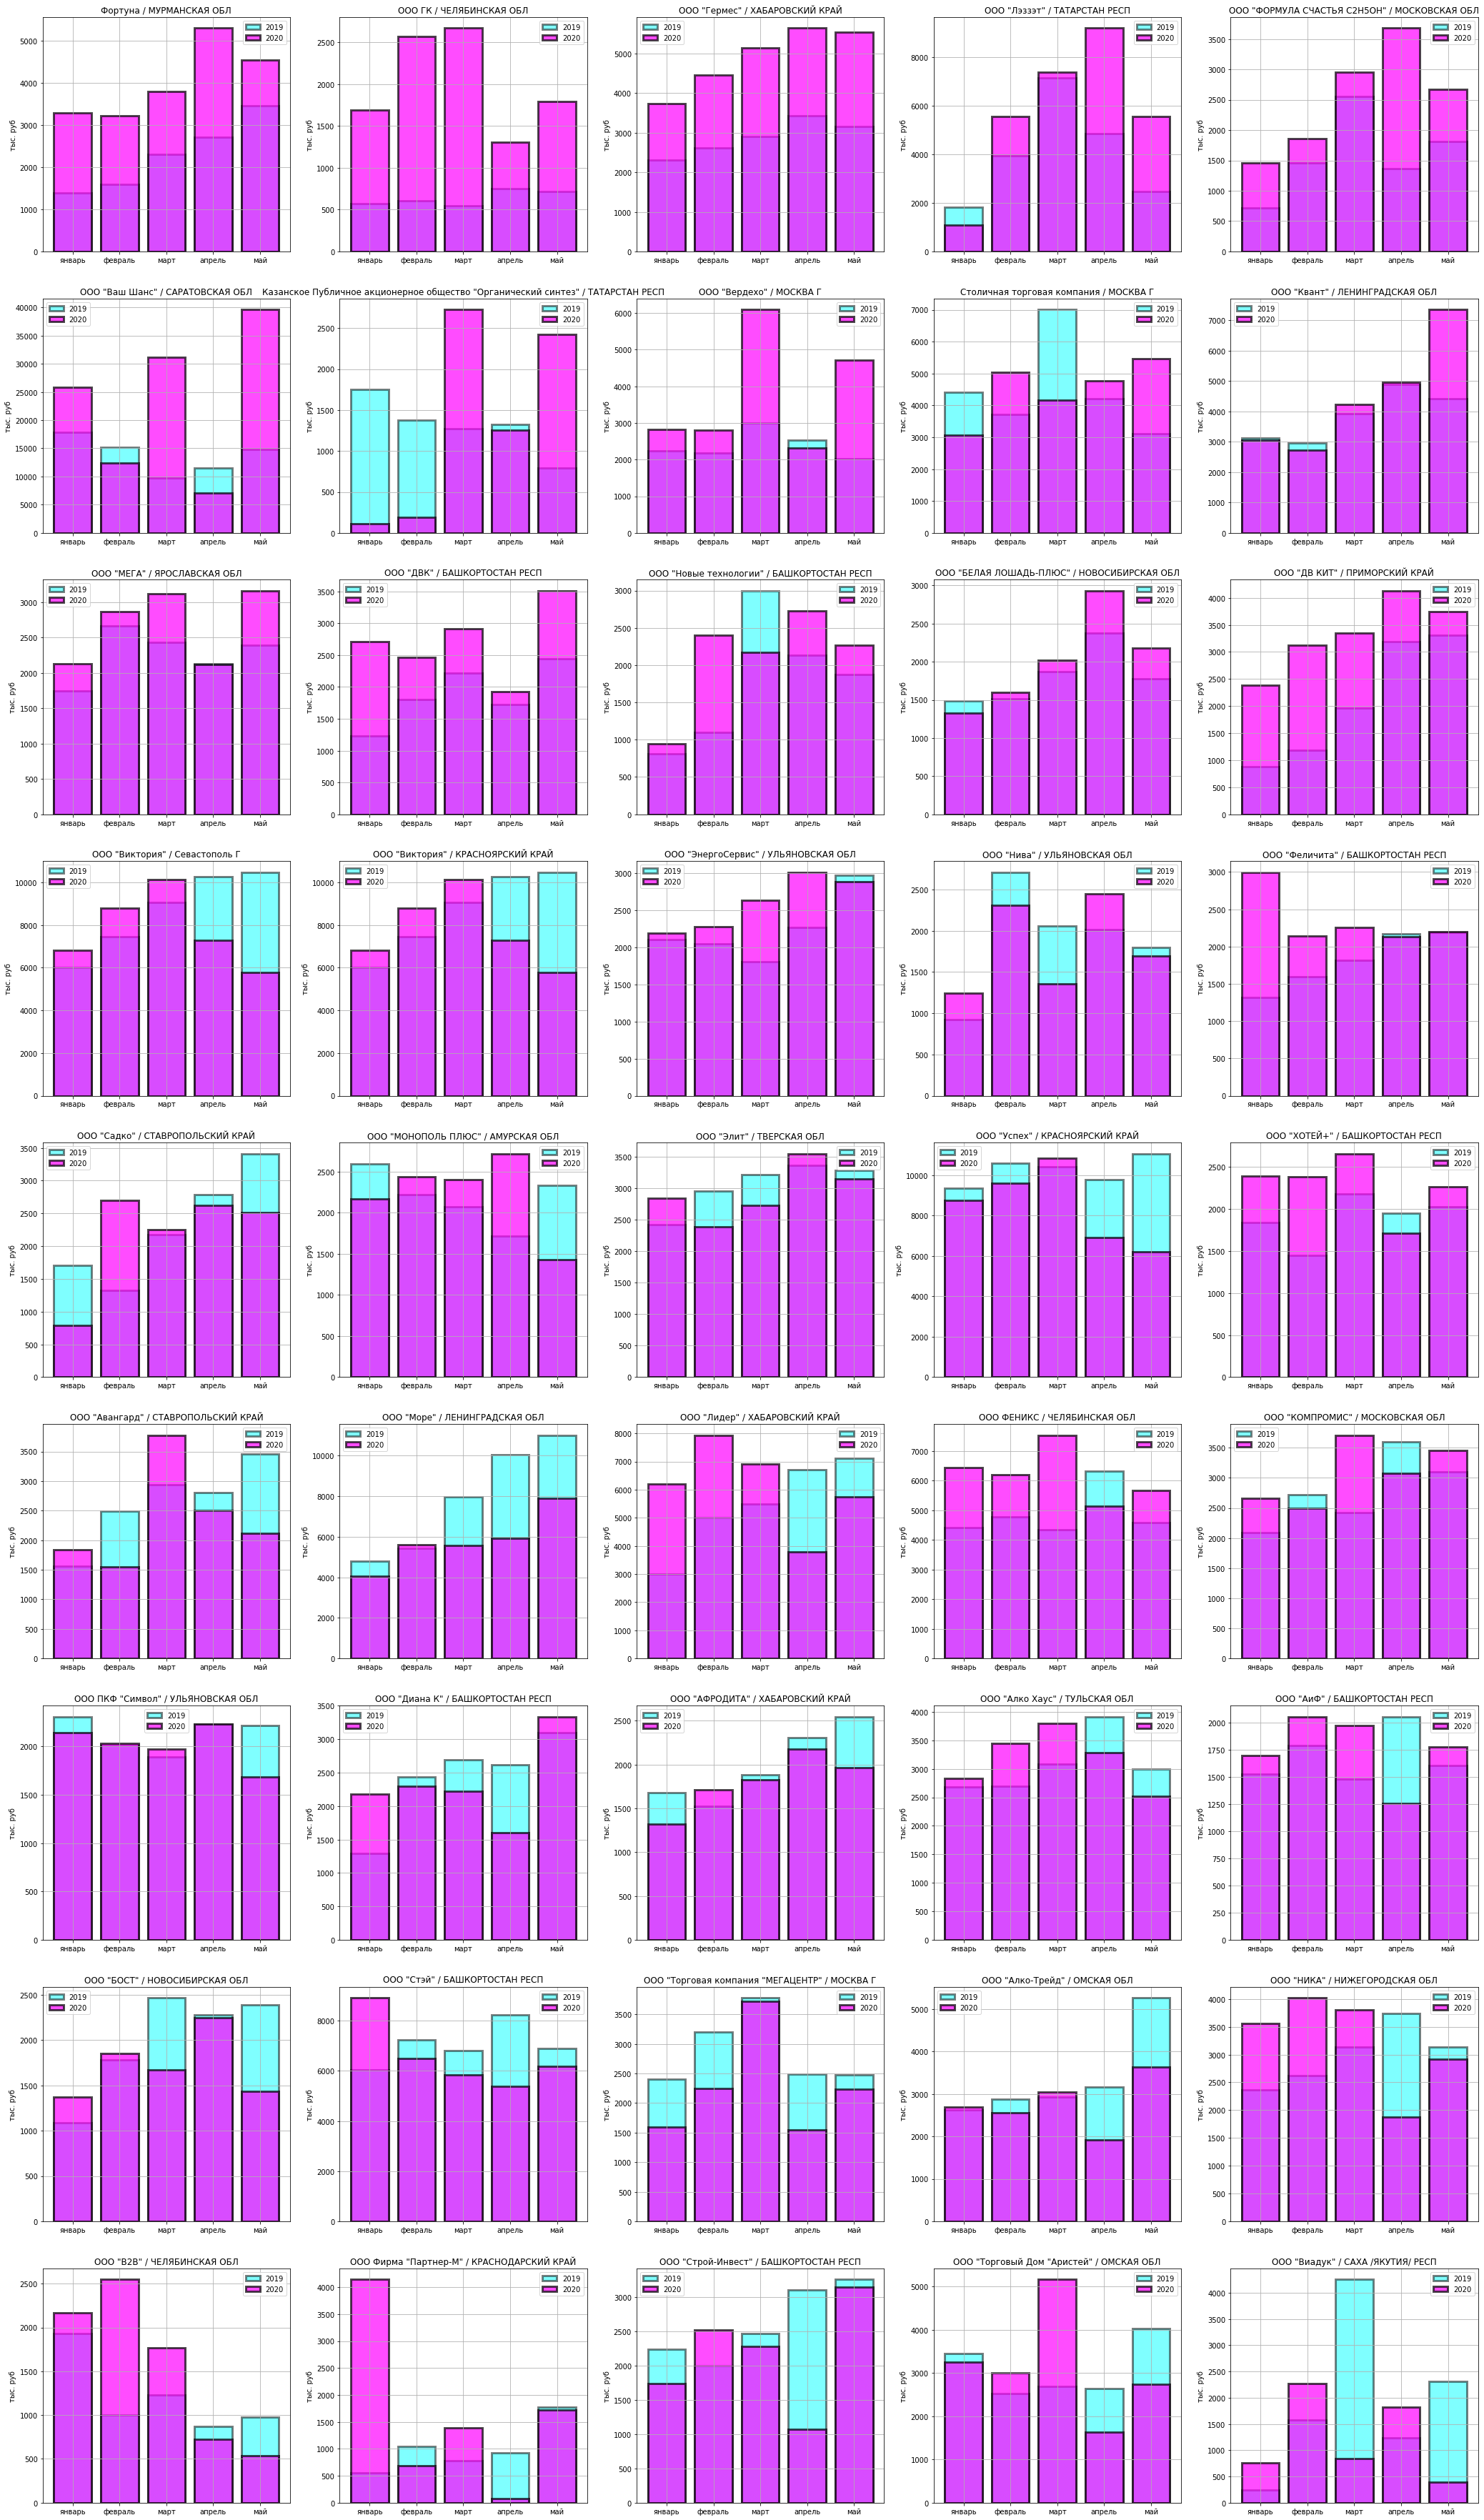

In [385]:
plt.figure(figsize=(36, 64))
for i in range(45):
    try:
        contr = non_stop_worked_top_45[i][0]
        plt.subplot(9, 5, i + 1)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']<=201905) & (wb['Consignee_Short_Name']==contr) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['summ_rub'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='cyan', label='2019', alpha=0.5)
        plt.bar(['январь', 'февраль', 'март', 'апрель', 'май'], wb[(wb['year_mon']>=202001) & (wb['Consignee_Short_Name']==contr) & (wb['type_activity']=='Розничная продажа, общепит')].groupby('year_mon')['summ_rub'].agg(lambda x: x.sum()/10**3).values,
               edgecolor='black', linewidth=3, color='magenta', label='2020', alpha=0.7)
        plt.title(contr + ' / ' + non_stop_worked_top_45[i][1])
        plt.grid()
        plt.legend()
        plt.ylabel('тыс. руб')
    except ValueError:
        pass
plt.show();

# Возможно это корпоративный общепит, судя по названиям..

# Закупки во время карантина еще не означают торговлю, в следующем анализе попытаюсь присовокупить акты списания